# pyiron_core
https://github.com/BAMresearch/NFDI4IngScientificWorkflowRequirements

## Define workflow with pyiron_core

In [1]:
import ast
import functools
import os
import inspect

In [2]:
from pyiron_core import Workflow, as_function_node
import pyiron_core.pyironflow.api as pyironflow
from pyiron_core.pyiron_nodes.utilities import GetItem
from pyiron_core.pyiron_workflow.simple_workflow import Node
from pyiron_core.pyiron_workflow.wf_graph_tools import _different_indices, _edges_from_dict, _nodes_from_dict, _filter_and_flatten_nested_dict_keys, _rename_keys, _get_node_labels, _find_input_nodes, get_nodes_from_wf, topological_sort, WorkflowGraph

In [3]:
from python_workflow_definition.models import PythonWorkflowDefinitionWorkflow
from python_workflow_definition.shared import (
    NODES_LABEL,
    EDGES_LABEL,
    SOURCE_LABEL,
    SOURCE_PORT_LABEL,
    TARGET_LABEL,
    TARGET_PORT_LABEL,
    VERSION_LABEL,
    VERSION_NUMBER,
)

In [4]:
def get_graph_from_wf(wf: "Workflow") -> WorkflowGraph:
    # get edges between nodes
    keys_to_keep = ["target", "targetHandle", "source", "sourceHandle"]
    edges = _filter_and_flatten_nested_dict_keys(pyironflow.get_edges(wf), keys_to_keep)

    # add edges for non-default inputs
    nodes = get_nodes_from_wf(
        wf,
        keys_to_keep=[
            "data/label",
            "data/import_path",
            "data/target_values",
            "data/target_labels",
            "data/source_values",
            "data/source_labels",
        ],
    )
    nodes_non_default_inp_param = []
    for node in nodes:
        label = node["label"]
        import_path = node["import_path"]
        try:
            node_obj = pyironflow.get_node_from_path(import_path)()
        except TypeError:
            node_obj = as_function_node(pyironflow.get_node_from_path(import_path), labels=node["data__source_labels"])()
        changed_args = _different_indices(
            node_obj.inputs.data["default"], node["data__target_values"]
        )
        for i in changed_args:
            value = node["data__target_values"][i]
            handle = node["data__target_labels"][i]
            if value not in ("NonPrimitive", "NotData"):
                inp_node_label = f"var_{label}__{handle}"
                edge = {
                    "target": label,
                    "targetHandle": handle,
                    "source": inp_node_label,
                    "sourceHandle": value,
                }

                edges.append(edge)
                inp_node = {"label": inp_node_label, "data__import_path": value}
                nodes_non_default_inp_param.append(inp_node)

        nodes = get_nodes_from_wf(
            wf,
            keys_to_keep=["data/label", "data/import_path"],
        )

    key_mapping = {"data__label": "label", "data__import_path": "import_path"}
    nodes = _rename_keys(nodes_non_default_inp_param + nodes, key_mapping=key_mapping)

    graph = WorkflowGraph(
        nodes=_nodes_from_dict(nodes), edges=_edges_from_dict(edges), label=wf.label
    )
    sorted_graph = topological_sort(graph)

    return sorted_graph

In [5]:
def pull_node(wf: "Workflow", node_label: str):
    """
    Pull a node from the workflow graph and run it. Execute only nodes that
    are required as input to run the node.

    Args:
        wf (Workflow): The workflow containing the node.
        node_label (str): The label of the node to pull.
    """
    graph = get_graph_from_wf(wf)
    node_labels = _get_node_labels(graph)
    if node_label not in node_labels:
        raise ValueError(f"Node label '{node_label}' not found in the workflow graph.")
    node_index = node_labels.index(node_label)
    input_nodes = _find_input_nodes(graph, node_index)
    input_nodes_labels = [node_labels[i] for i in input_nodes]

    for input_node_label in input_nodes_labels:
        out = wf._nodes[input_node_label].run()
    return out


In [6]:
def get_inputs(node):
    return {key: getattr(node.inputs, key).value for key in dir(node.inputs) if not isinstance(getattr(node.inputs, key).value, Node)}

In [7]:
def get_links(node):
    return {key: getattr(node.inputs, key).value.label for key in dir(node.inputs) if isinstance(getattr(node.inputs, key).value, Node)}

In [8]:
def get_node_dict(wf):
    node_dict = {}
    for key in wf.child_labels:
        value = getattr(wf, key)
        node_dict[key] = {
            "inputs": get_inputs(node=value),
            "links": get_links(node=value),
            "function": value._func.__module__ + "." + value._func.__name__,
        }
    return node_dict

In [9]:
def get_nodes_and_edges(node_dict):
    input_nodes_lst = []
    nodes_lst = []
    translate_dict = {}
    link_dict = {}
    edge_lst = []
    for k, v in node_dict.items():
        node_id = len(nodes_lst)
        if "inputs" in v:
            for key, value in v["inputs"].items():
                link_dict[len(input_nodes_lst)] = {
                    TARGET_LABEL: node_id, TARGET_PORT_LABEL: key, SOURCE_PORT_LABEL: None
                }
                input_nodes_lst.append({"type": "input", "value": value, "name": key})
        if "links" in v:
            for key, value in v['links'].items():
                edge_lst.append({TARGET_LABEL: node_id, TARGET_PORT_LABEL: key, SOURCE_LABEL: translate_dict[value], SOURCE_PORT_LABEL: None})
        nodes_lst.append({"id": node_id, "type": "function", "value": v['function']})
        translate_dict[k] = node_id
    
    for i, node in enumerate(input_nodes_lst):
        node_id = len(nodes_lst)
        edge_lst.append({SOURCE_LABEL: node_id} | link_dict[i])
        nodes_lst.append({"id": node_id, "type": "input", "value": node["value"], "name": node["name"]})

    return nodes_lst, edge_lst

In [10]:
def remove_helper_nodes(nodes_lst, edge_lst):
    nodes_to_remove = [n["id"] for n in nodes_lst if n["value"] == 'pyiron_core.pyiron_nodes.utilities.GetItem']

    new_edge_lst = []
    new_nodes_lst = []
    edge_remove_lst = []
    nodes_total_to_remove = nodes_to_remove[:]
    for n in nodes_to_remove:
        new_edge_dict = {}
        for i, e in enumerate(edge_lst):
            if e[TARGET_LABEL] == n and e[TARGET_PORT_LABEL] == "obj":
                edge_remove_lst.append(i)
                new_edge_dict[SOURCE_LABEL] = e[SOURCE_LABEL]
            elif e[TARGET_LABEL] == n and e[TARGET_PORT_LABEL] == 'index':
                edge_remove_lst.append(i)
                new_edge_dict[SOURCE_PORT_LABEL] = [node['value'] for node in nodes_lst if node["id"] == e[SOURCE_LABEL]][0]
                nodes_total_to_remove.append(e[SOURCE_LABEL])
            elif e[SOURCE_LABEL] == n:
                edge_remove_lst.append(i)
                new_edge_dict[TARGET_PORT_LABEL] = e[TARGET_PORT_LABEL]
                new_edge_dict[TARGET_LABEL] = e[TARGET_LABEL]
        new_edge_lst.append(new_edge_dict)
    
    for i, e in enumerate(edge_lst):
        if i not in edge_remove_lst:
            new_edge_lst.append(e)
    
    for n in nodes_lst:
        if n["id"] not in nodes_total_to_remove:
            new_nodes_lst.append(n)

    return new_nodes_lst, new_edge_lst

In [11]:
def reorder(nodes_lst, edge_lst):
    translate_dict = {k["id"]:v for v,k in enumerate(nodes_lst)}
    
    final_nodes_lst = []
    for node in nodes_lst:
        node["id"] = translate_dict[node["id"]]
        final_nodes_lst.append(node)
    
    final_edge_lst = []
    for edge in edge_lst:
        edge[TARGET_LABEL] = translate_dict[edge[TARGET_LABEL]]
        edge[SOURCE_LABEL] = translate_dict[edge[SOURCE_LABEL]]
        final_edge_lst.append(edge)
    
    return final_nodes_lst, final_edge_lst

In [12]:
def add_result_node(nodes_lst, edge_lst, final_node_id):
    edge_lst += [{TARGET_LABEL: final_node_id, TARGET_PORT_LABEL: None, SOURCE_LABEL: [n["id"] for n in nodes_lst if n["type"] == "function"][-1], SOURCE_PORT_LABEL: None}]
    nodes_lst += [{"id": final_node_id, "type": "output", "name": "result"}]
    return nodes_lst, edge_lst

In [13]:
from workflow import (
    generate_mesh as _generate_mesh, 
    convert_to_xdmf as _convert_to_xdmf,
    poisson as _poisson,
    plot_over_line as _plot_over_line,
    substitute_macros as _substitute_macros,
    compile_paper as _compile_paper,
)

In [14]:
domain_size = 2.0

In [15]:
source_directory = os.path.abspath(os.path.join(os.curdir, "source"))

In [16]:
generate_mesh = as_function_node(_generate_mesh, labels=["result"])
convert_to_xdmf = as_function_node(_convert_to_xdmf, labels=["result"])
poisson = as_function_node(_poisson, labels=["result"])
plot_over_line = as_function_node(_plot_over_line, labels=["result"])
substitute_macros = as_function_node(_substitute_macros, labels=["result"])
compile_paper = as_function_node(_compile_paper, labels=["result"])

In [17]:
wf = Workflow("nfdi4ing")
wf.gmsh_output_file = generate_mesh(
    domain_size=domain_size,
    source_directory=source_directory,
)
wf.meshio_output_dict = convert_to_xdmf(
    gmsh_output_file=wf.gmsh_output_file,
)
wf.meshio_output_dict_xdmf_file = GetItem(wf.meshio_output_dict, "xdmf_file")
wf.meshio_output_dict_h5_file = GetItem(wf.meshio_output_dict, "h5_file")
wf.poisson_dict = poisson(
    meshio_output_xdmf=wf.meshio_output_dict_xdmf_file, 
    meshio_output_h5=wf.meshio_output_dict_h5_file,
    source_directory=source_directory,
)
wf.poisson_dict_pvd_file = GetItem(wf.poisson_dict, "pvd_file")
wf.poisson_dict_vtu_file = GetItem(wf.poisson_dict, "vtu_file")
wf.poisson_dict_numdofs = GetItem(wf.poisson_dict, "numdofs")
wf.pvbatch_output_file = plot_over_line(
    poisson_output_pvd_file=wf.poisson_dict_pvd_file, 
    poisson_output_vtu_file=wf.poisson_dict_vtu_file,
    source_directory=source_directory,
)
wf.macros_tex_file = substitute_macros( 
    pvbatch_output_file=wf.pvbatch_output_file, 
    ndofs=wf.poisson_dict_numdofs, 
    domain_size=domain_size,
    source_directory=source_directory,
)
wf.paper_output = compile_paper(
    macros_tex=wf.macros_tex_file, 
    plot_file=wf.pvbatch_output_file,
    source_directory=source_directory,
)

In [18]:
workflow_json_filename = "pyiron_core_nfdi.json"

In [19]:
nodes_lst, edge_lst = get_nodes_and_edges(node_dict=get_node_dict(wf=wf))
new_nodes_lst, new_edge_lst = remove_helper_nodes(nodes_lst=nodes_lst, edge_lst=edge_lst)
new_nodes_lst, new_edge_lst = add_result_node(nodes_lst=new_nodes_lst, edge_lst=new_edge_lst, final_node_id=len(nodes_lst))
final_nodes_lst, final_edge_lst = reorder(nodes_lst=new_nodes_lst, edge_lst=new_edge_lst)
PythonWorkflowDefinitionWorkflow(
    **{
        VERSION_LABEL: VERSION_NUMBER,
        NODES_LABEL: final_nodes_lst,
        EDGES_LABEL: final_edge_lst,
    }
).dump_json_file(file_name=workflow_json_filename, indent=2)

## Load Workflow with pyiron_base

In [20]:
from python_workflow_definition.pyiron_base import load_workflow_json

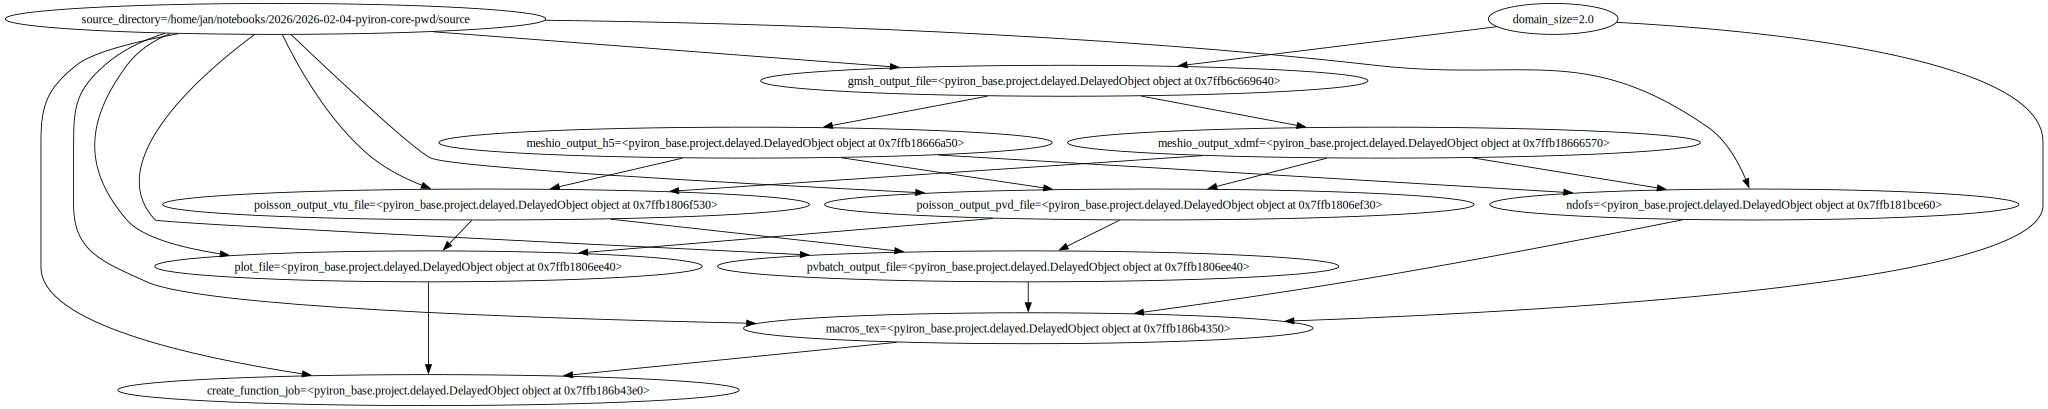

In [21]:
delayed_object_lst = load_workflow_json(file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [22]:
delayed_object_lst[-1].pull()

INFO:pyiron_log:run job: generate_mesh id: None, status: initialized
DEBUG:pyiron_log:sql_query: {'job': 'generate_mesh', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
DEBUG:pyiron_log:sql_query: {'job': 'generate_mesh', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/%'}
DEBUG:pyiron_log:sql_query: {'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
INFO:pyiron_log:run job: generate_mesh_efefecc1e0b6f0c722299e0e3006ac35 id: 57, status: created


The job generate_mesh_efefecc1e0b6f0c722299e0e3006ac35 was saved and received the ID: 57


INFO:pyiron_log:run job: convert_to_xdmf id: None, status: initialized
DEBUG:pyiron_log:sql_query: {'job': 'convert_to_xdmf', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
DEBUG:pyiron_log:sql_query: {'job': 'convert_to_xdmf', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/%'}
DEBUG:pyiron_log:sql_query: {'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
INFO:pyiron_log:run job: convert_to_xdmf_0ad4672b75fea34088b0c70a550b4240 id: 58, status: created


The job convert_to_xdmf_0ad4672b75fea34088b0c70a550b4240 was saved and received the ID: 58


INFO:pyiron_log:run job: convert_to_xdmf id: None, status: initialized
DEBUG:pyiron_log:sql_query: {'job': 'convert_to_xdmf', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
DEBUG:pyiron_log:sql_query: {'job': 'convert_to_xdmf', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/%'}
DEBUG:pyiron_log:sql_query: {'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
INFO:pyiron_log:run job: poisson id: None, status: initialized
DEBUG:pyiron_log:sql_query: {'job': 'poisson', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
DEBUG:pyiron_log:sql_query: {'job': 'poisson', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/%'}
DEBUG:pyiron_log:sql_query: {'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
INFO:pyiron_log:run job: poisson_20cb224cd32355381872a81936a7d8f0 id: 59, status: created


The job poisson_20cb224cd32355381872a81936a7d8f0 was saved and received the ID: 59


/home/jan/miniforge3/envs/processing/lib/python3.9/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
INFO:pyiron_log:run job: poisson id: None, status: initialized
DEBUG:pyiron_log:sql_query: {'job': 'poisson', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
DEBUG:pyiron_log:sql_query: {'job': 'poisson', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/%'}
DEBUG:pyiron_log:sql_query: {'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
INFO:pyiron_log:run job: poisson id: None, status: initialized
DEBUG:pyiron_log:sql_query: {'job': 'poisson', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
DEBUG:pyiron_log:sql_query: {'job': 'poisson', 'project': '/home/jan/notebooks/2026/

The job plot_over_line_3dce48c8db062af151a2bef63dc24e36 was saved and received the ID: 60


INFO:pyiron_log:run job: substitute_macros id: None, status: initialized
DEBUG:pyiron_log:sql_query: {'job': 'substitute_macros', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
DEBUG:pyiron_log:sql_query: {'job': 'substitute_macros', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/%'}
DEBUG:pyiron_log:sql_query: {'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
INFO:pyiron_log:run job: substitute_macros_cdc660861030d9ca17195b5db4616d5c id: 61, status: created


The job substitute_macros_cdc660861030d9ca17195b5db4616d5c was saved and received the ID: 61


INFO:pyiron_log:run job: compile_paper id: None, status: initialized
DEBUG:pyiron_log:sql_query: {'job': 'compile_paper', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
DEBUG:pyiron_log:sql_query: {'job': 'compile_paper', 'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/%'}
DEBUG:pyiron_log:sql_query: {'project': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/'}
INFO:pyiron_log:run job: compile_paper_de1b620df0f0da260aa27ab0316988ba id: 62, status: created


The job compile_paper_de1b620df0f0da260aa27ab0316988ba was saved and received the ID: 62


'/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/postprocessing/paper.pdf'

## Load Workflow with pyiron_workflow

In [23]:
from python_workflow_definition.pyiron_workflow import load_workflow_json

In [24]:
wf = load_workflow_json(file_name=workflow_json_filename)

INFO:pyiron_log:Assigning a channel with the label domain_size to the io key generate_mesh__domain_size
INFO:pyiron_log:Assigning a channel with the label source_directory to the io key generate_mesh__source_directory
INFO:pyiron_log:Assigning a channel with the label source_directory to the io key poisson__source_directory
INFO:pyiron_log:Assigning a channel with the label source_directory to the io key plot_over_line__source_directory
INFO:pyiron_log:Assigning a channel with the label domain_size to the io key substitute_macros__domain_size
INFO:pyiron_log:Assigning a channel with the label source_directory to the io key substitute_macros__source_directory
INFO:pyiron_log:Assigning a channel with the label source_directory to the io key compile_paper__source_directory
INFO:pyiron_log:Assigning a channel with the label item to the io key injected_GetItem_m2023877963071051148__item
INFO:pyiron_log:Assigning a channel with the label item to the io key injected_GetItem_m37645937947954711

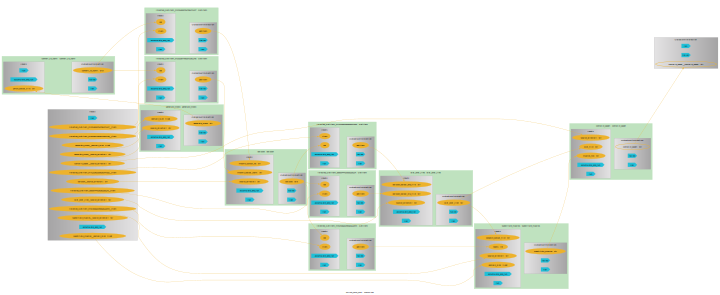

In [25]:
wf.draw(size=(10,10))

In [26]:
wf.run()

INFO:pyiron_log:Assigning a channel with the label domain_size to the io key generate_mesh__domain_size
INFO:pyiron_log:Assigning a channel with the label source_directory to the io key generate_mesh__source_directory
INFO:pyiron_log:Assigning a channel with the label source_directory to the io key poisson__source_directory
INFO:pyiron_log:Assigning a channel with the label source_directory to the io key plot_over_line__source_directory
INFO:pyiron_log:Assigning a channel with the label domain_size to the io key substitute_macros__domain_size
INFO:pyiron_log:Assigning a channel with the label source_directory to the io key substitute_macros__source_directory
INFO:pyiron_log:Assigning a channel with the label source_directory to the io key compile_paper__source_directory
INFO:pyiron_log:Assigning a channel with the label item to the io key injected_GetItem_m2023877963071051148__item
INFO:pyiron_log:Assigning a channel with the label item to the io key injected_GetItem_m37645937947954711

{'compile_paper__compile_paper': '/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/postprocessing/paper.pdf'}

## Load Workflow with executorlib

In [27]:
from executorlib import SingleNodeExecutor

In [28]:
from python_workflow_definition.executorlib import load_workflow_json

In [29]:
with SingleNodeExecutor(max_workers=1) as exe:
    result = load_workflow_json(file_name=workflow_json_filename, exe=exe).result()

/home/jan/miniforge3/envs/processing/lib/python3.9/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [30]:
result

'/home/jan/notebooks/2026/2026-02-04-pyiron-core-pwd/postprocessing/paper.pdf'